# Интернет-магазине «Стримчик»

Даны данные до 2016 года. 
Нужно отработать принцип работы с данными. Выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [67]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt
import missingno as msno


In [68]:
data = pd.read_csv('games.csv')

In [69]:
data.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
13872,WSC Real 11: World Snooker Championship,X360,2011.0,Sports,0.00,0.03,0.00,0.00,NaN,NaN,NaN
10577,Guitar Hero: Van Halen,PS2,2009.0,Misc,0.05,0.04,0.00,0.01,NaN,tbd,T
2368,Resident Evil: Revelations,3DS,2012.0,Action,0.30,0.22,0.30,0.05,82.0,8.5,M
15017,The Lord of the Rings: Conquest,PC,2009.0,Action,0.00,0.02,0.00,0.00,57.0,6.7,T
15402,Aquanaut's Holiday,PS,1995.0,Adventure,0.01,0.01,0.00,0.00,NaN,NaN,NaN
4346,Samurai Warriors: Xtreme Legends,PS2,2004.0,Action,0.04,0.03,0.36,0.01,72.0,8.6,T
7137,Zumba Fitness: World Party,Wii,2013.0,Misc,0.11,0.10,0.00,0.02,NaN,tbd,E
6234,Castlevania: Aria of Sorrow,GBA,2003.0,Platform,0.20,0.07,0.00,0.00,91.0,9.1,T
9960,Dora the Explorer: Journey to the Purple Planet,GC,2005.0,Adventure,0.09,0.02,0.00,0.00,NaN,tbd,EC
6526,Don King Boxing,Wii,2009.0,Sports,0.14,0.09,0.00,0.03,55.0,tbd,T


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [71]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
Name,0.000000
Platform,0.000000
Year_of_Release,2.000000
Genre,0.000000
NA_sales,0.000000
EU_sales,0.000000
JP_sales,0.000000
Other_sales,0.000000
Critic_Score,51.000000
User_Score,40.000000


<Axes: >

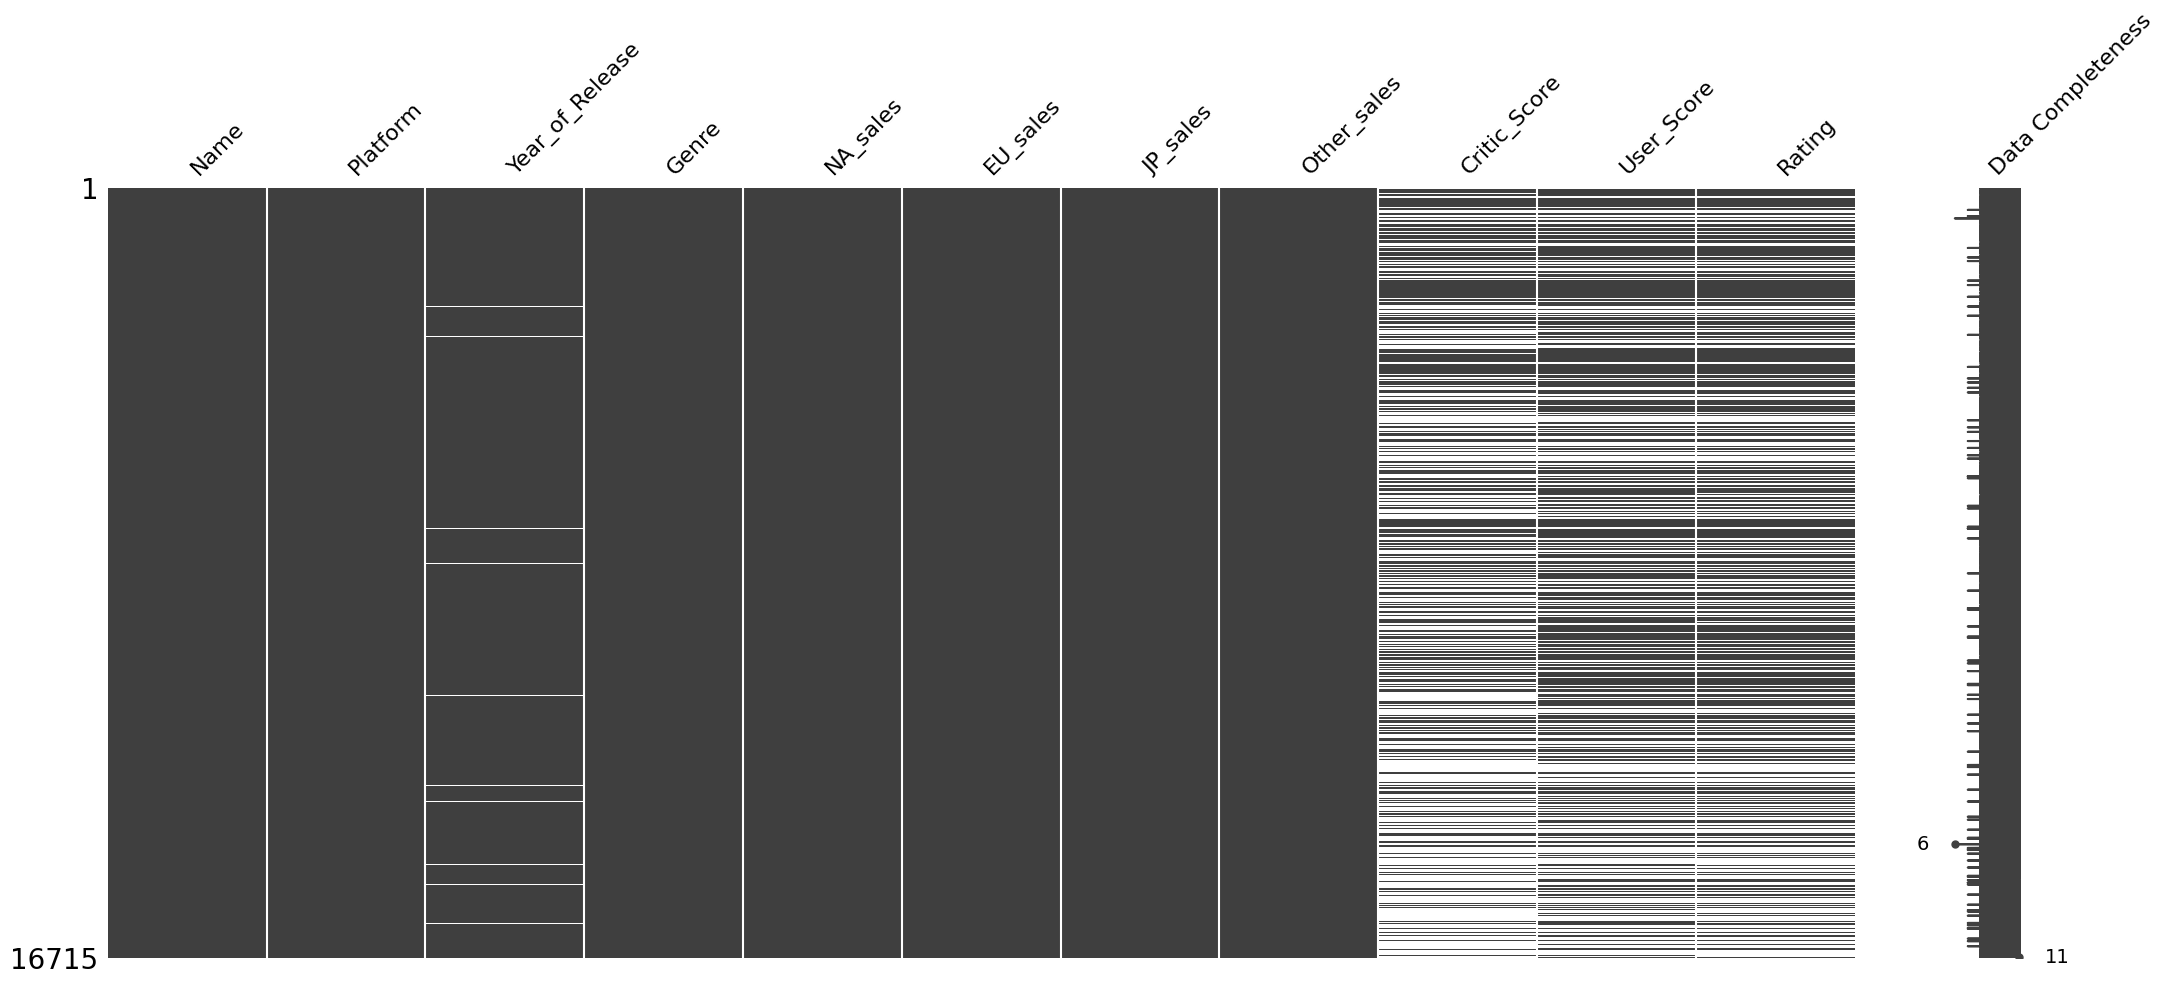

In [72]:
msno.matrix(data, labels=True) 
plt.show()

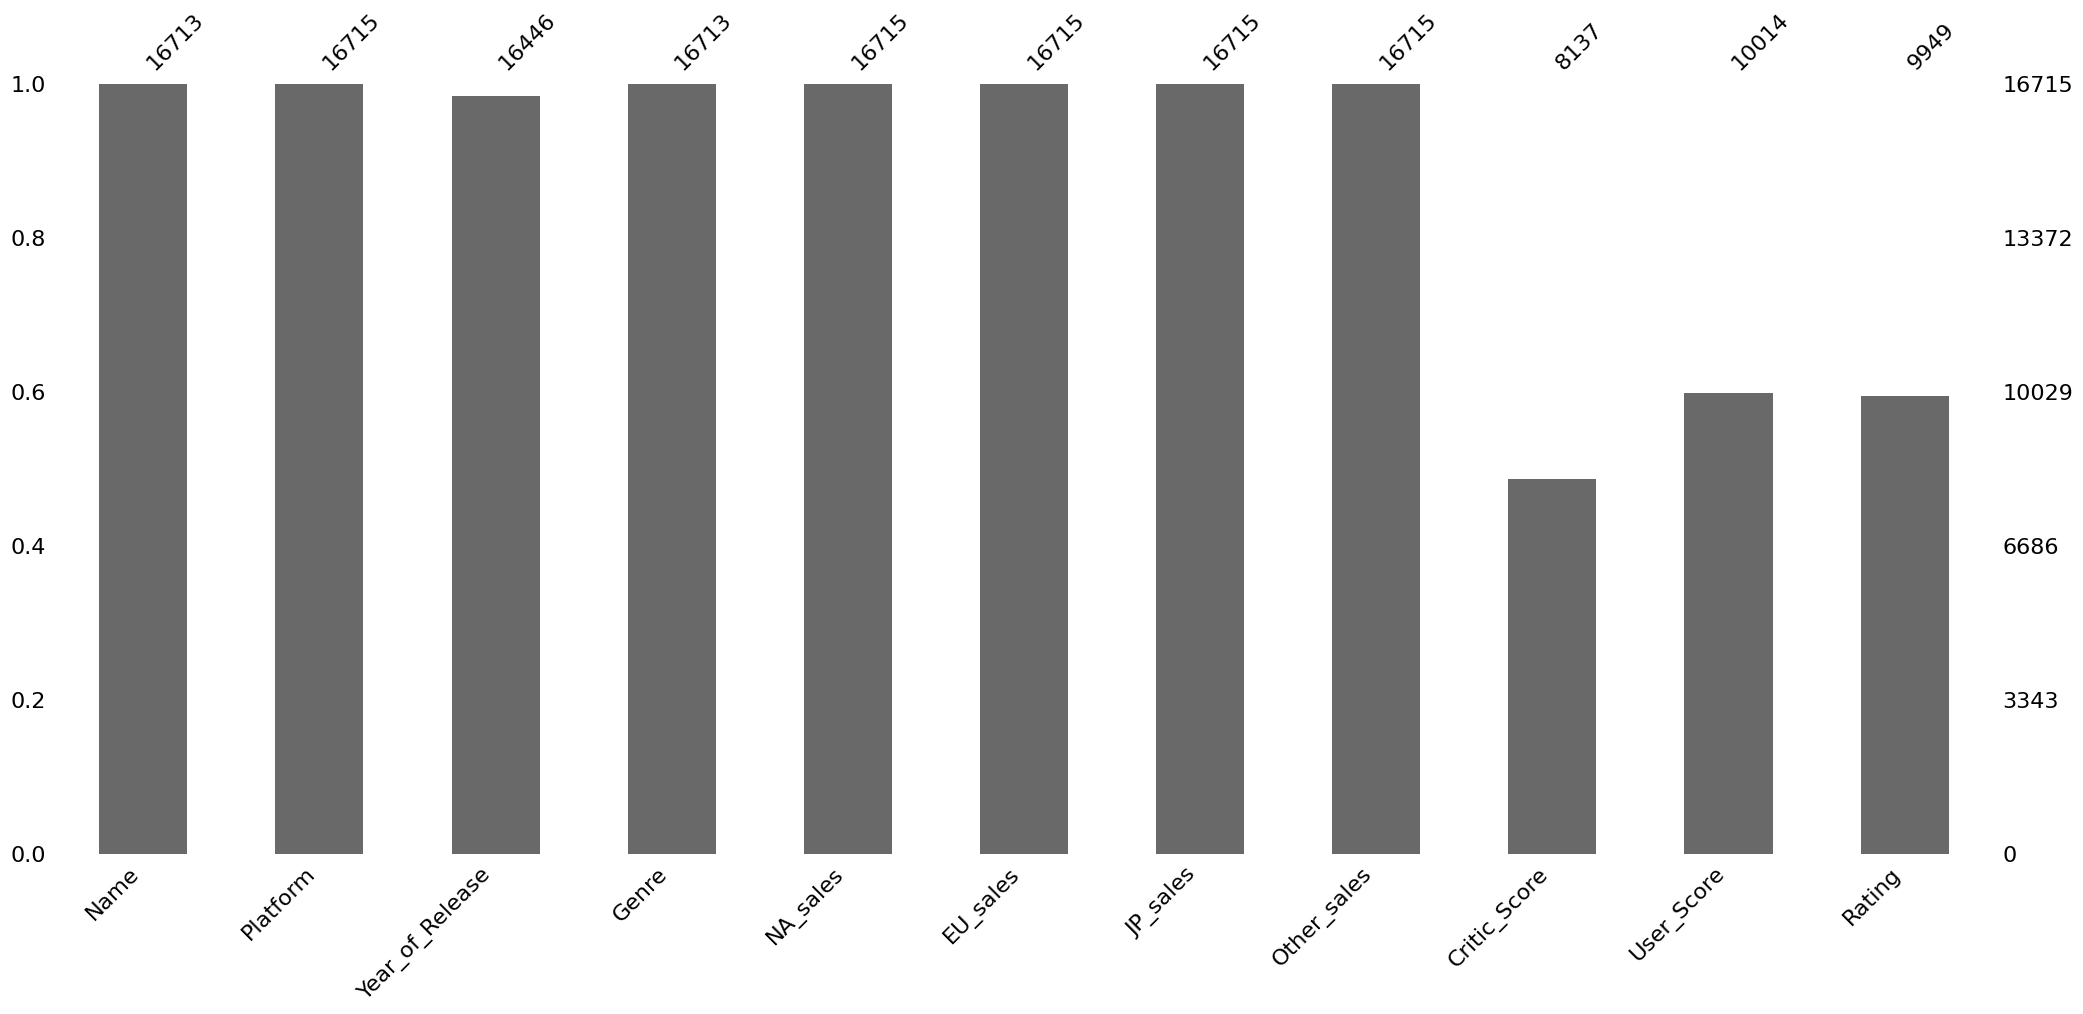

In [73]:
msno.bar(data)
plt.show()

In [74]:
#Посчитаем количество дубликатов.
data.duplicated().sum()

0

Очень большое количество пропусков по столбцам critic_score, rating и user_score  - которые вляются важными перементарами для проведения анализа.  Дубликатов нет.

critic_score - оценка критиков -  возможно, что игры не оценивались критиками. Было бы неправильно заполнить рейтинг игры средним или медианой, даже если бы мы их считали внутри для каждого жанра отдельно. Для быстрой фильтрации данных и возможность обрабатывать данные, поставим этим играм рейтинг 0;

user_score - те же причины, вероятно, ранее не было сервисов, которые собирали бы рейтинги игроков. Поэтому и присутствуют пропуски. Поступим так же, как и со столбцом critic_score.

rating - рейтинг от ESRB - здесь то же самое. Невозможно дать рейтинг игре, посчитав его как среднее рейтингов игр того же жанра. Поставим рейтинг "Unknown";

Столбец year_of_release имеет относительно не много пропусков. Средними/медианами эти пропуски не заполнить, но целых данных достаточно для анализа, поэтому оставляем как есть.


## Шаг 2. Подготовьте данные

### Заменить названия столбцов (приведите к нижнему регистру)

Для удобства работы приведем названия столбцов к нижнему регистру:

In [75]:
data.columns = data.columns.str.lower()

In [76]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Преобразуем данные в нужные типы. 

Приведем столбец year_of_release к формату integer

In [77]:
data['year_of_release'] = data['year_of_release'].astype('Int32')

In [78]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Изменение типа данных по столбцу user_score. Сначала посмотрим содержание:

In [79]:
data['user_score'].sort_values(na_position='first').unique()

array([nan, '0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1',
       '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1',
       '2.2', '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1',
       '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1',
       '4.2', '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1',
       '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1',
       '6.2', '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1',
       '7.2', '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1',
       '8.2', '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1',
       '9.2', '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd'], dtype=object)

Помимо пропусков, видим "tbd". Посмотрим, сколько их там таких:

In [80]:
data[data['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,<NA>,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


In [81]:
data[data['user_score'] == '0']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2835,My Little Pony: Pinkie Pie's Party,DS,2008,Adventure,0.66,0.0,0.0,0.06,NaN,0,E


Погуглив, найдем, что это аббревиатура от To Be Determined. Это значит, что игра имеет недостаточное количество отзывов (менее 4) для подсчета рейтинга  и его публикации. Заменим NaN и 'tbd' на значение 0 и приведем значение столбца к числовому. С нулевым рейтингом всего игра, то есть на аналитику такой выбор заменыне повлияет.

In [82]:
data['user_score'] = data['user_score'].replace('tbd', np.NaN).astype('float')
data['user_score'] = data['user_score'].fillna(0)

In [83]:
data['user_score'].sort_values(na_position='first').unique()

array([0. , 0.2, 0.3, 0.5, 0.6, 0.7, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5,
       1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8,
       2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1,
       4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4,
       5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7,
       6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ,
       8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1, 9.2, 9.3,
       9.4, 9.5, 9.6, 9.7])

Изменение типа данных по столбцу critic_score. Сначала посмотрим содержание:

In [84]:
data['critic_score'].sort_values(na_position='first').unique()

array([nan, 13., 17., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
       42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54.,
       55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67.,
       68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80.,
       81., 82., 83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93.,
       94., 95., 96., 97., 98.])

In [85]:
data['critic_score'] = data['critic_score'].fillna(0)

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int32  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     16715 non-null  float64
 9   user_score       16715 non-null  float64
 10  rating           9949 non-null   object 
dtypes: Int32(1), float64(6), object(4)
memory usage: 1.4+ MB


Посмотрим на таблицу с пустыми значениями в столбце rating.

In [87]:
data[data['rating'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0.0,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,0.0,0.0,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,0.0,0.0,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,0.0,0.0,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,0.0,0.0,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,0.0,0.0,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,0.0,0.0,NaN


In [88]:
data['rating'] = data['rating'].fillna('Unknown')

### Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [89]:
#data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [90]:
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int32  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     16715 non-null  float64
 9   user_score       16715 non-null  float64
 10  rating           16715 non-null  object 
 11  total_sales      16715 non-null  float64
dtypes: Int32(1), float64(7), object(4)
memory usage: 1.5+ MB


Данные подготовлены к анализу:

- Название столбцов было приведено к нижнему регистру
- Восстановлены пропуски в строках.
- Добавлен столбец суммарных продаж.

Приступим к анализы данных.

## Шаг 3. Проведите исследовательский анализ данных

### Cколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [92]:
year_of_release_pivot_table = pd.pivot_table(data, index='year_of_release', values='name', aggfunc='count')
year_of_release_pivot_table.columns = ['games_count']
year_of_release_pivot_table.style.background_gradient('coolwarm')

,games_count
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


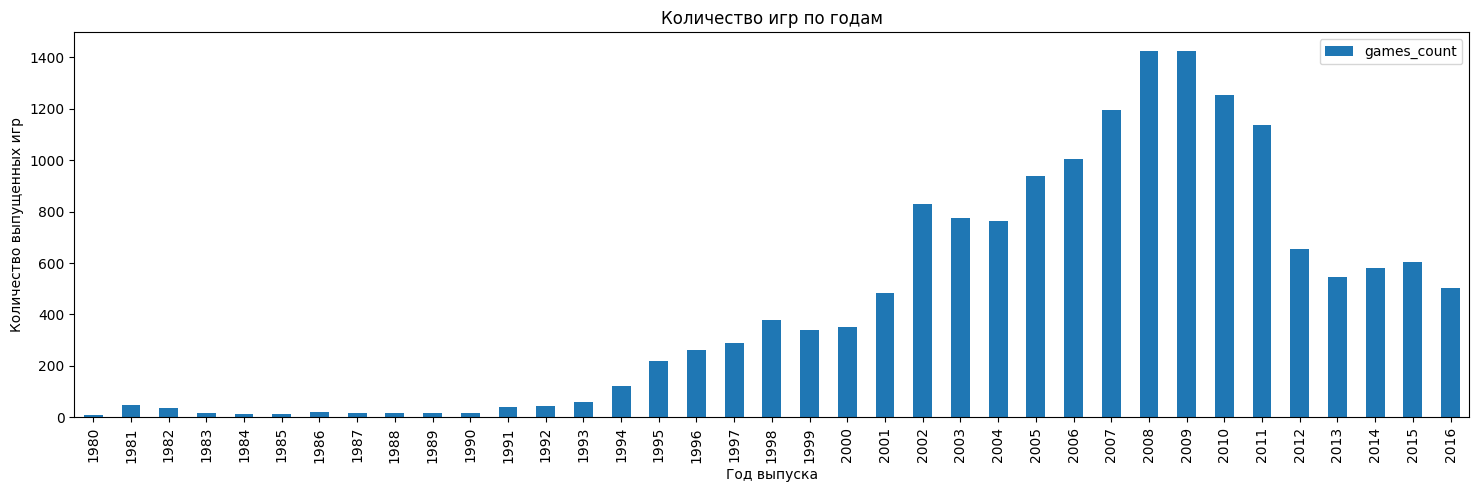

In [93]:
year_of_release_pivot_table.plot(kind='bar', figsize=(18,5))
plt.title("Количество игр по годам")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")
plt.show()

На графике видно, что с 1993  количество игр начинает ежегодно расти быстрыми темпами. Из Wiki "1990-е годы были ознаменованы заметными инновациями в компьютерных играх. Основными достижениями называют переход от растровой графики к полностью полигональному 3D, снижение популярности аркадных игр и появление нескольких новых жанров - шутер от первого лица, стратегия в реальном времени и MMO".

В 2002 году видно, что выпустилось много игр.  "2002-й был своего рода переходным периодом. Мы увидели целую плеяду продолжений известных игр. Из глубоких недр вышли на поверхность самые именитые долгострои. Cтали появляться игры с качественно новым уровнем графики, принципиально новыми технологиями. Словно в 2002-м индустрия прощалась с проектами прошлого и показывала, какой она предстанет нам в недалеком будущем."

Пик в 2009 это не только популярность к созданию компьютерных игр, но и распространенность компьютерных движков, некоторые из которых бесплатны к использованию на сегодняшний день.

Спад индустри игр с 2012 по 2016 обусловлен экономическим кризисом и требованиям к игре. Крупные студии-разработчики как Blizzard создают игры по 10-15 лет, так как хотят порадовать своих фанатов новым гемплеем, современными технологиями и новой графикой.

### Как менялись продажи по платформам. За какой характерный срок появляются новые и исчезают старые платформы?

In [94]:
platform_sales_pivot_table = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
platform_sales_pivot_table.style.background_gradient('coolwarm')

,total_sales
platform,
PS2,1255.770000
X360,971.420000
PS3,939.650000
Wii,907.510000
DS,806.120000
PS,730.860000
GBA,317.850000
PS4,314.140000
PSP,294.050000


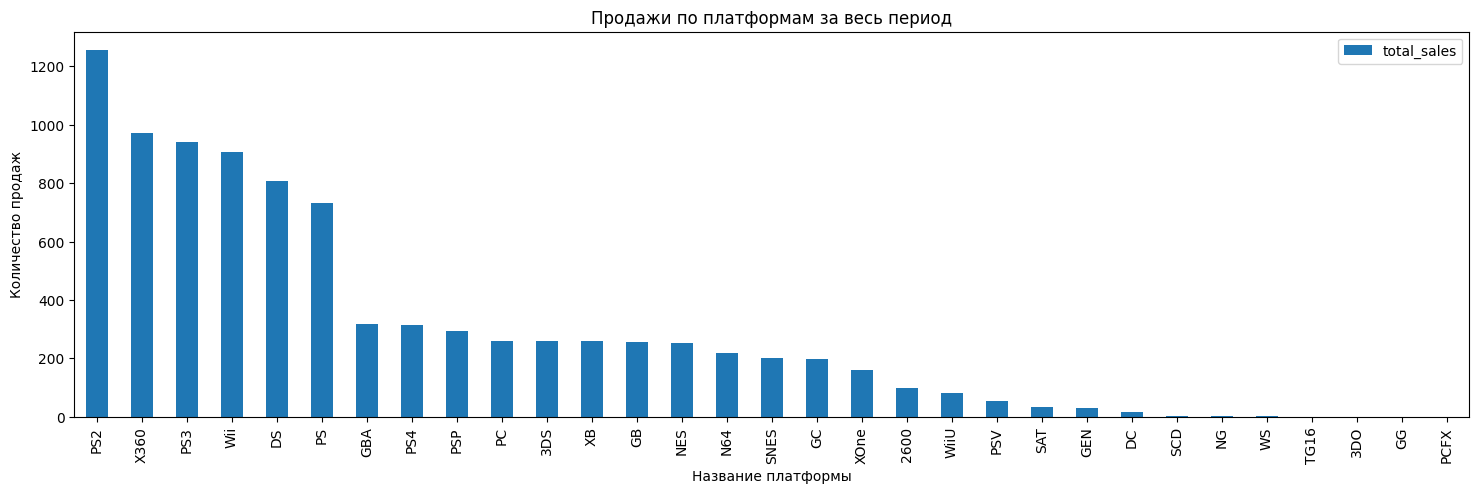

In [95]:
platform_sales_pivot_table.plot(kind='bar', figsize=(18,5))
plt.title("Продажи по платформам за весь период")
plt.xlabel("Название платформы")
plt.ylabel("Количество продаж")
plt.show()

Рассмотрим ТОП -6 платформ

In [96]:
top_platforms_list = list(platform_sales_pivot_table.index[:6])
top_platforms_list

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

Безусловным лидером является платформа PS2. Далее идут Xbox360, PS3 и Wii.
Самые редкие платформы - представители японских технологий.

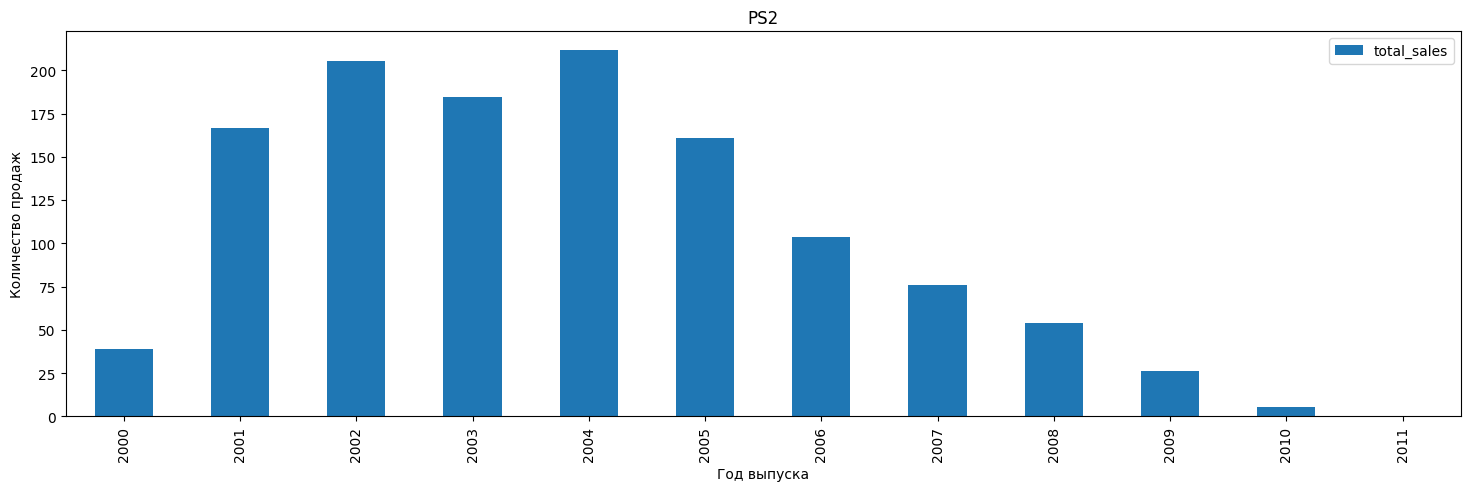

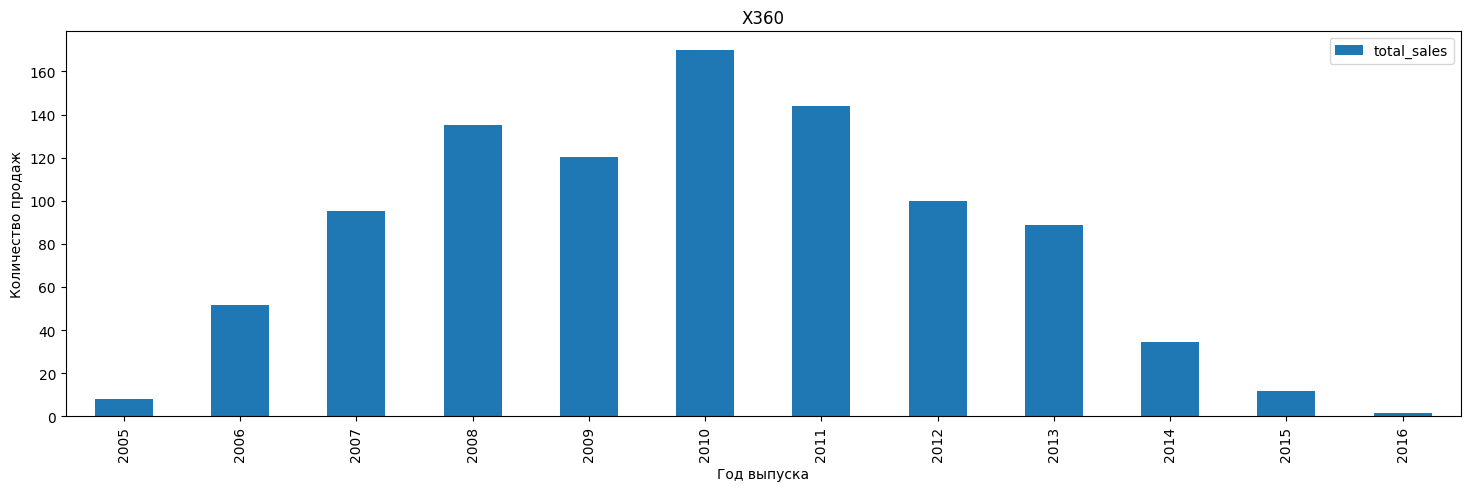

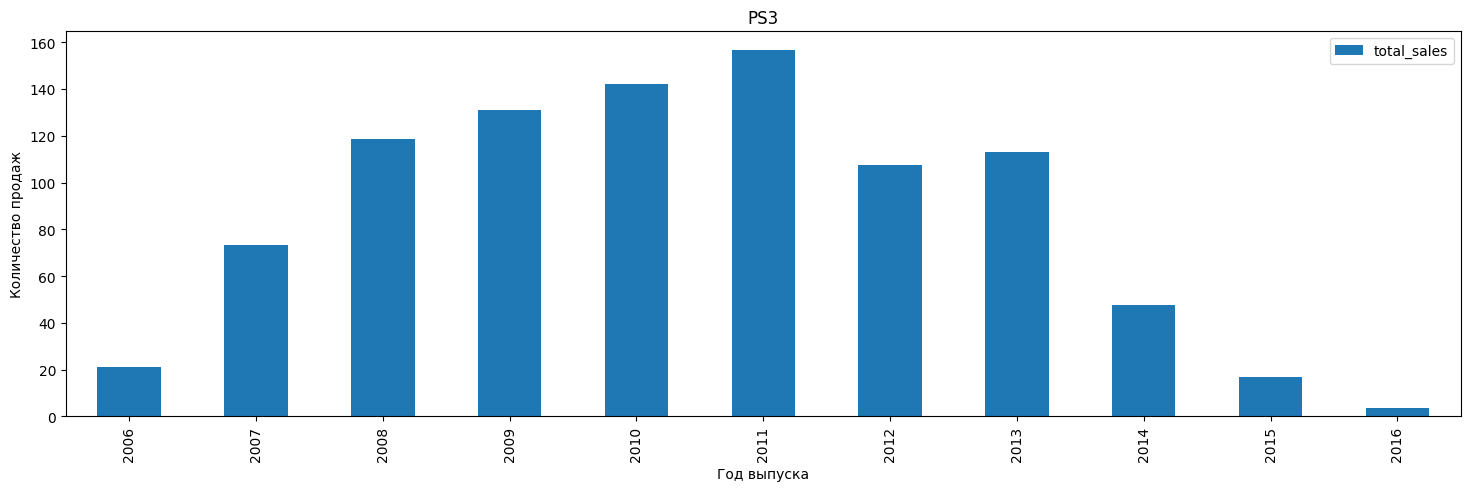

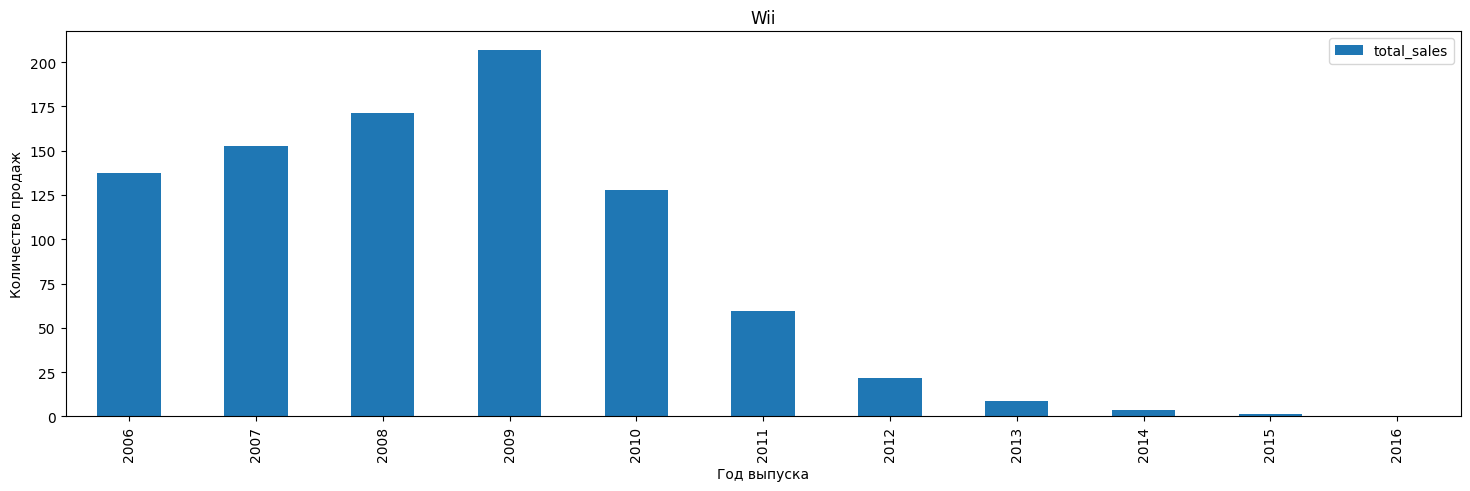

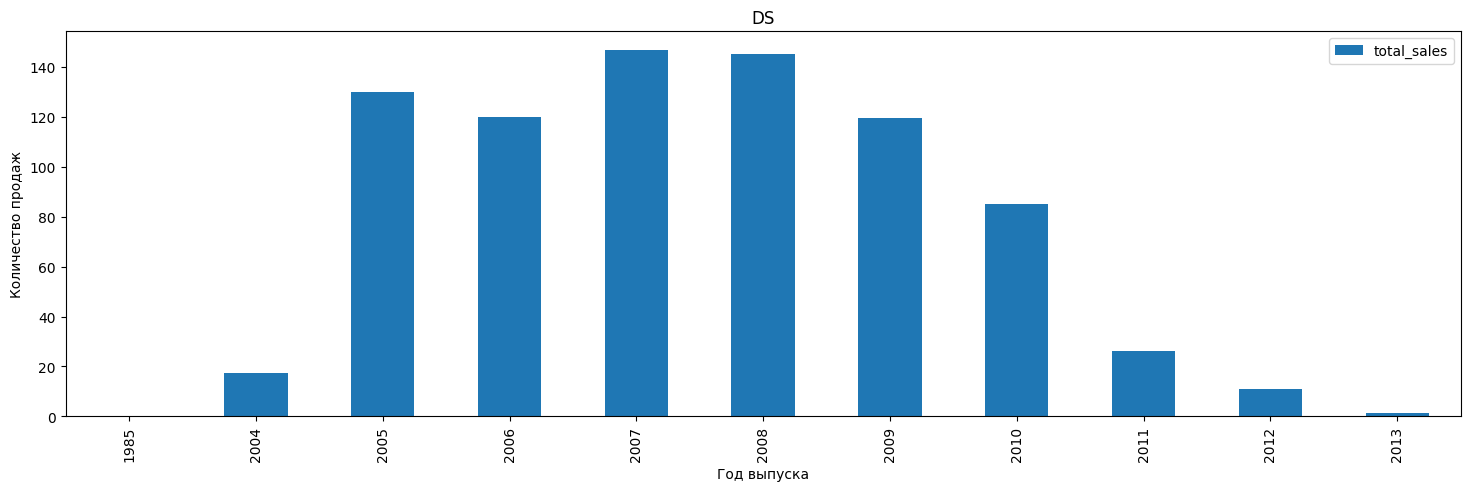

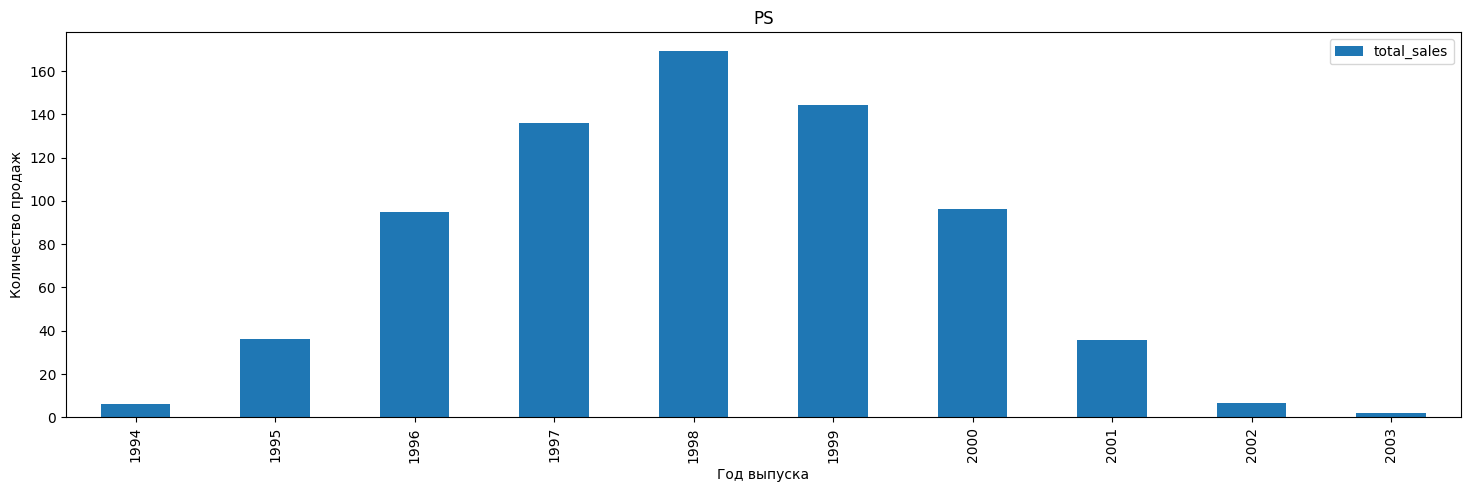

In [97]:
for platform in top_platforms_list:
    data[data['platform'] == platform].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')\
    .plot(kind='bar', figsize=(18,5))
    plt.xlabel("Год выпуска")
    plt.ylabel("Количество продаж")
    plt.title(platform)

Из диаграмм распределения, можно сделать вывод, что средний период 'жизни' платформ длится 8-10 лет.
Шестерка лидирующих по продажам за всё время платформ в нашем датасете теряет свое могущество к 2016 года.

In [98]:
year_2016 = data[data['year_of_release'] == 2016]
platform_2016_pivot_table = year_2016.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
platform_2016_pivot_table.style.background_gradient('coolwarm')

,total_sales
platform,
PS4,69.250000
XOne,26.150000
3DS,15.140000
PC,5.250000
WiiU,4.600000
PSV,4.250000
PS3,3.600000
X360,1.520000
Wii,0.180000


В 2016 году популярность удерживают PS4, XBOX One,  Nintendo 3DS, PC,Nintendo WiiU, PlayStation Vita.  

### Возьмем данные за  актуальный период, но основании которых можно построить прогноз на 2017 год.


Сейчас у нас выделяются 3 явных этапа развития индустрии: рост с 1993 до 2008 года, пик 2008 и 2009 годов, а также спад рынка последних годов.
Кроме того, выявили, что большей части платформ нет в 2016 году, поэтому из прогноза на 2017 год их исключим.
Будем рассматривать только конечный на данный момент интервал развития игровой индустрии. При уменьшении периода в рассмотрение попадут только последние поколения платформ поэтому возьмем 3 последние года.

In [99]:
period_data = data[data['year_of_release'] >= 2014 ]
period_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0.0,0.0,Unknown,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,0.0,0.0,Unknown,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,0.0,0.0,Unknown,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,0.0,0.0,Unknown,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,0.0,0.0,Unknown,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,0.0,0.0,Unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,0.0,0.0,Unknown,0.01


Cохраним в переменной top_6_platforms только последние поколения платформ и избавимся от выбросов

In [100]:
top_6_platforms = ['PS4', 'XOne', '3DS', 'PC', 'WiiU', 'PSV']

In [101]:
games_top_6_platforms = period_data[period_data['platform'].isin(top_6_platforms)]
games_top_6_platforms = games_top_6_platforms[games_top_6_platforms['total_sales']<1.4]
games_top_6_platforms

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1395,Yoshi's New Island,3DS,2014,Platform,0.48,0.53,0.28,0.09,64.0,6.1,E,1.38
1401,Mortal Kombat X,XOne,2015,Fighting,1.03,0.21,0.00,0.14,86.0,7.3,M,1.38
1403,Rise of the Tomb Raider,XOne,2015,Adventure,0.55,0.70,0.02,0.11,86.0,8.0,M,1.38
1434,Middle-Earth: Shadow of Mordor,XOne,2014,Action,0.73,0.50,0.01,0.12,87.0,8.0,M,1.36
1439,Gears of War 4,XOne,2016,Shooter,0.78,0.44,0.00,0.12,84.0,6.2,M,1.34
...,...,...,...,...,...,...,...,...,...,...,...,...
16699,The Longest 5 Minutes,PSV,2016,Action,0.00,0.00,0.01,0.00,0.0,0.0,Unknown,0.01
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,0.0,0.0,Unknown,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,0.0,0.0,Unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,0.0,0.0,Unknown,0.01


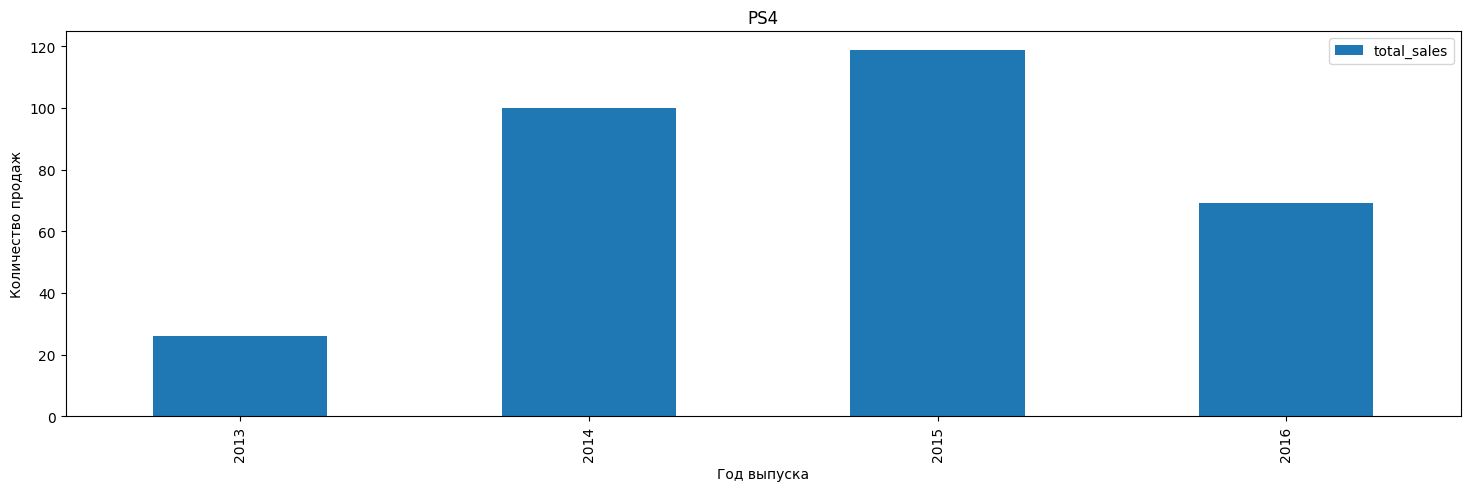

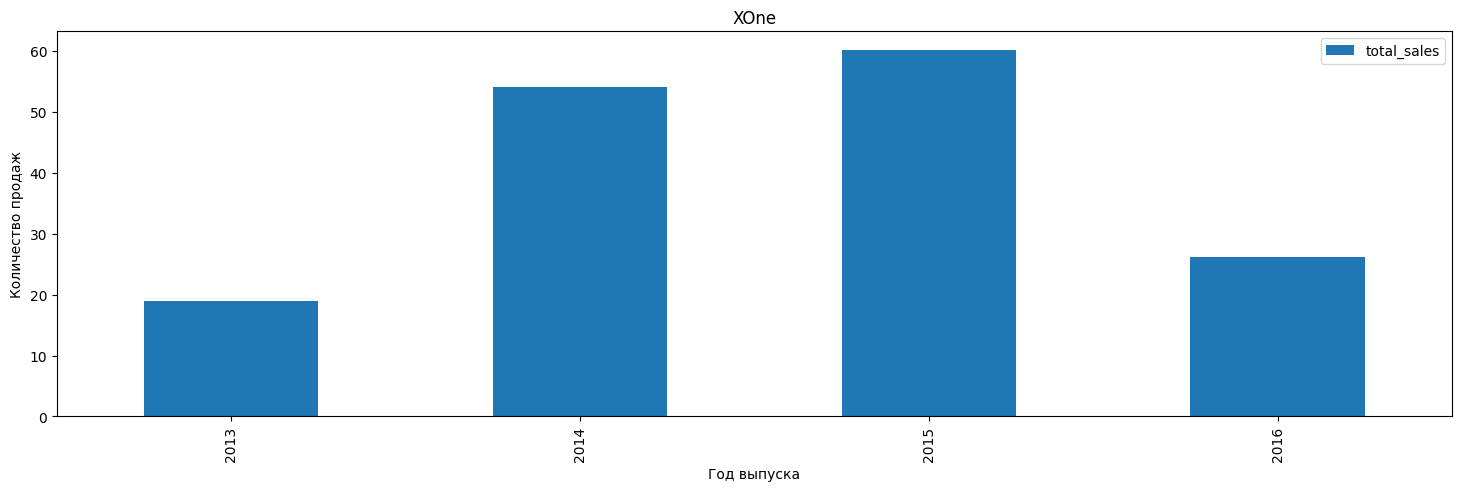

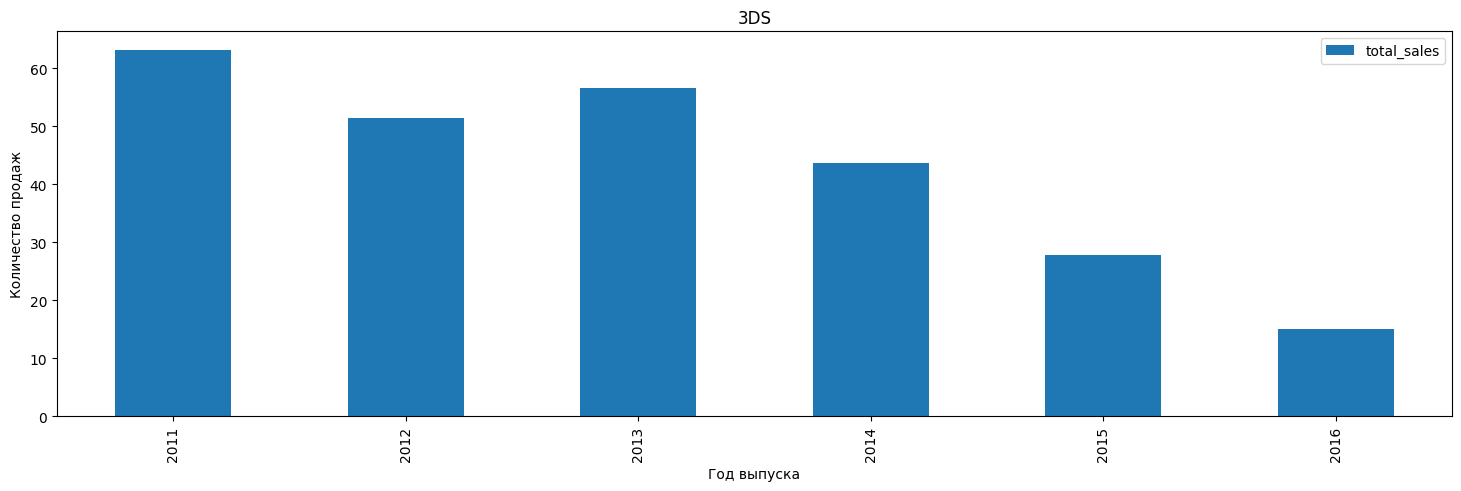

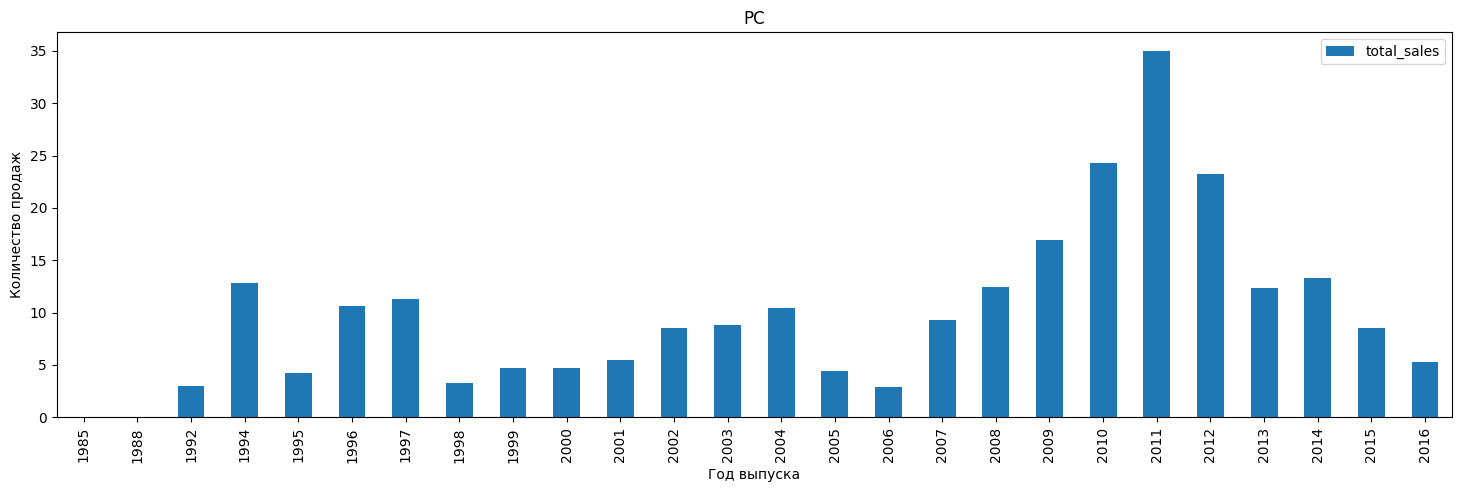

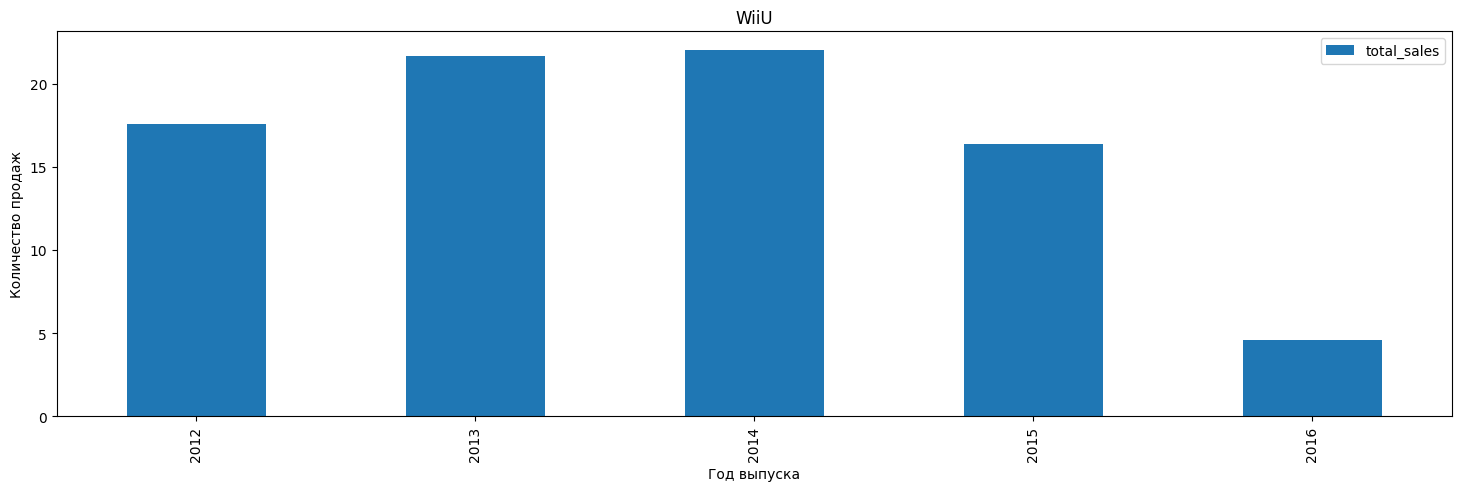

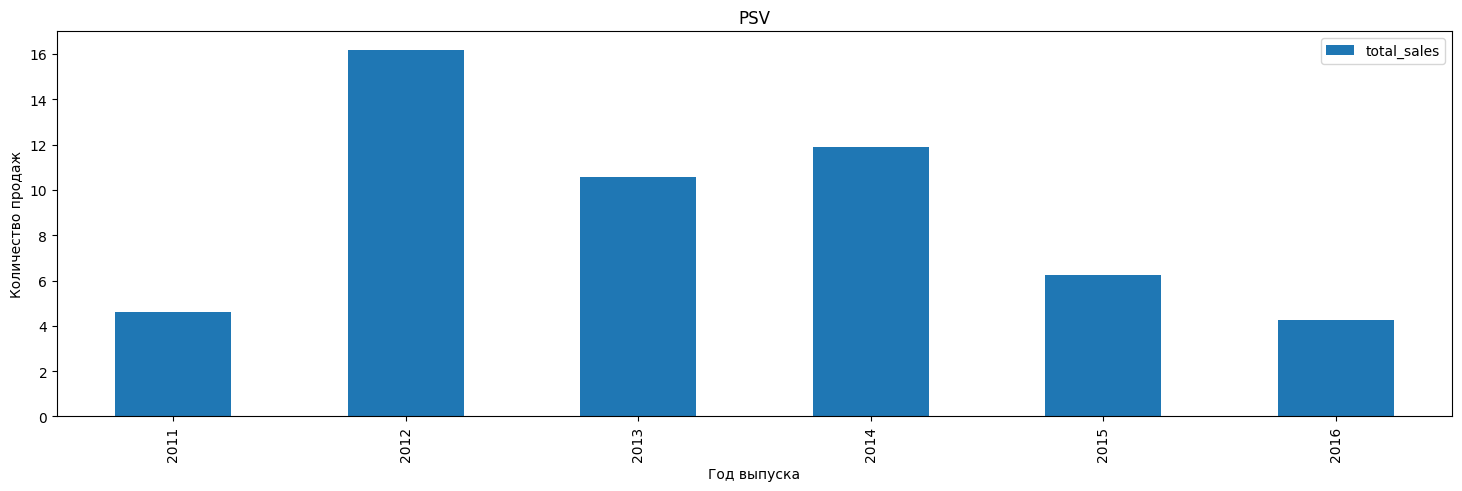

In [102]:
for platform in top_6_platforms:
    data[data['platform'] == platform].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')\
    .plot(kind='bar', figsize=(18,5))
    plt.xlabel("Год выпуска")
    plt.ylabel("Количество продаж")
    plt.title(platform)

In [103]:
games_top_6_platforms_sales=games_top_6_platforms.pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc='sum')
games_top_6_platforms_sales

total_sales
platform year_of_release             
3DS      2014                   12.85
         2015                   15.11
         2016                    8.00
PC       2014                   10.23
         2015                    8.52
         2016                    5.25
PS4      2014                   22.25
         2015                   31.08
         2016                   27.71
PSV      2014                    9.94
         2015                    6.25
         2016                    4.25
WiiU     2014                    8.54
         2015                    7.12
         2016                    4.60
XOne     2014                   17.45
         2015                   25.80
         2016                   16.66

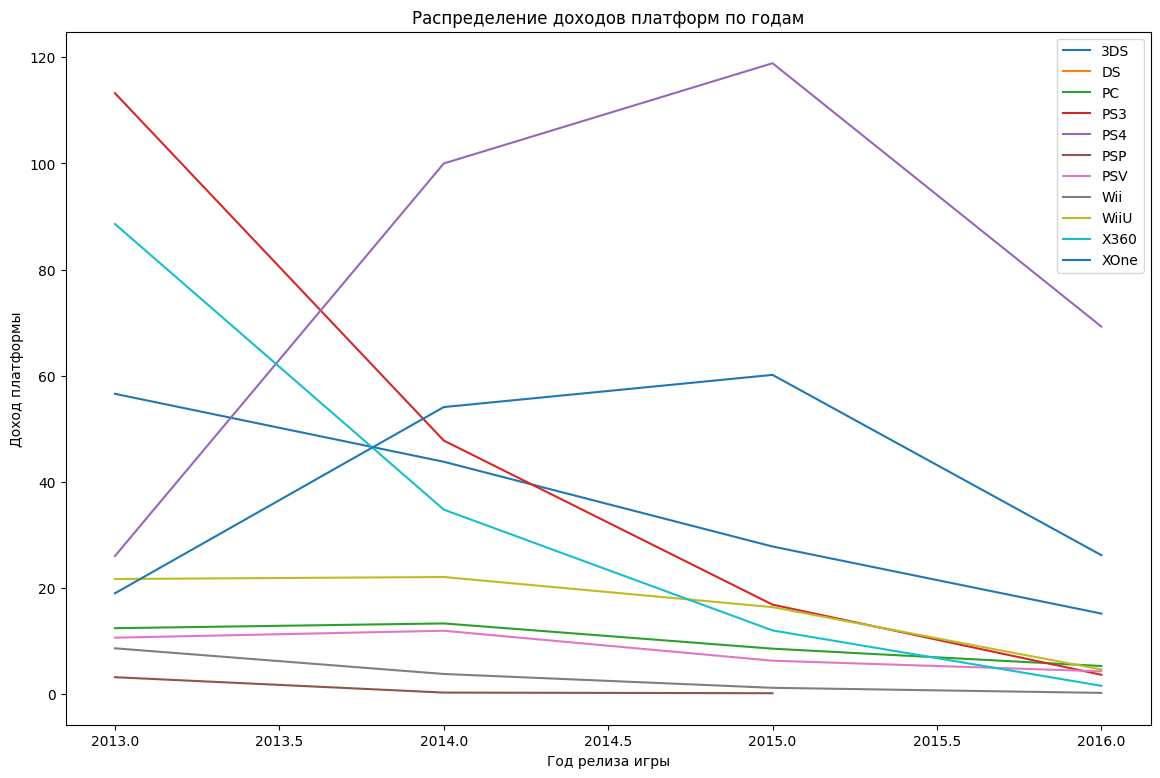

In [104]:
primer = data.query('year_of_release > 2012')
primer.pivot_table(index=['year_of_release'], columns='platform', values = 'total_sales', aggfunc = 'sum').plot(title='Распределение доходов платформ по годам', figsize = (14,9)).set(xlabel="Год релиза игры", ylabel="Доход платформы")
plt.legend(loc='upper right')
plt.show()


Исходя из данных диаграмм количество продаж по всем платформам снижается. Учитываю что средняя жизнь игровых консолей 8-10 лет можно предположить что потенциально прибыльными в 2017 году будут PS, XOne и PC.

###  Построим диаграмму размаха - ящик с усами

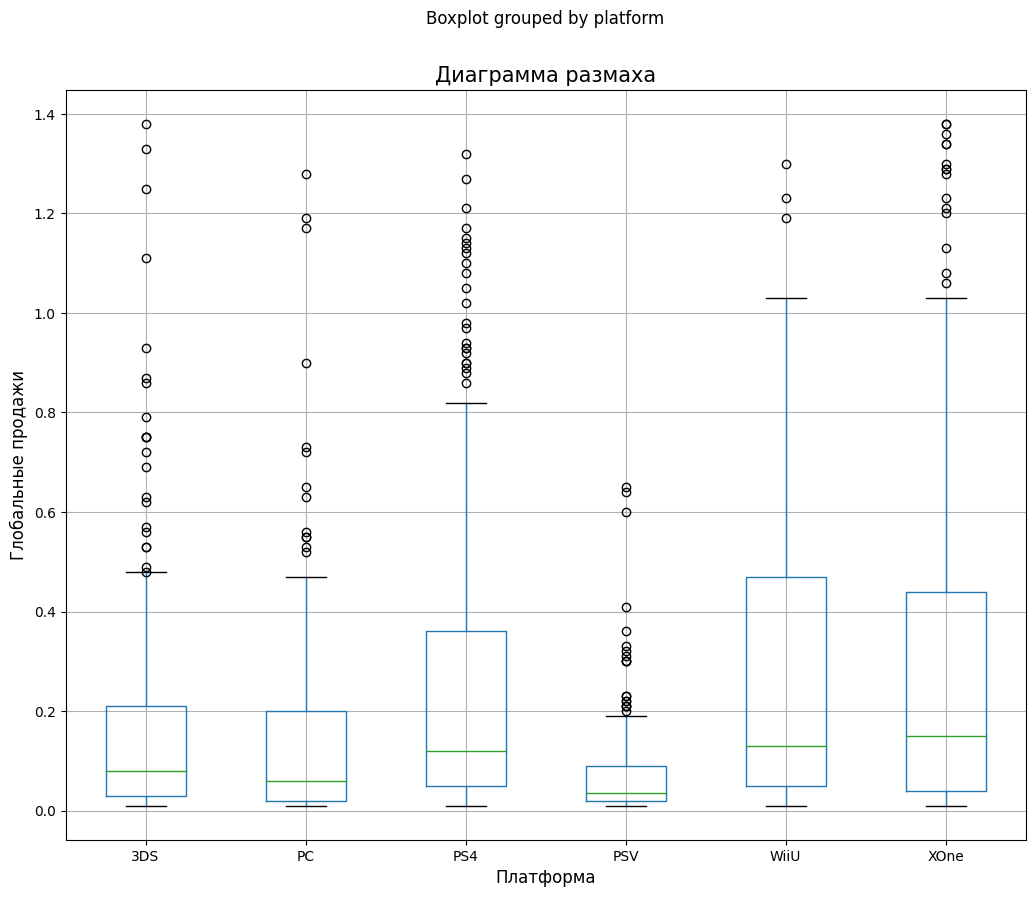

In [105]:
games_top_6_platforms.boxplot(column = 'total_sales', by='platform', figsize=(12,10))
plt.title('Диаграмма размаха', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи',fontsize=12)
plt.show()

Видно, что медиана на разном уровне. Больше всего продаж у WiiU, XOne, затем PS4, 3DS, PC и на последнем месте PSV .
Положение Xbox One и PlayStation 4 можно объяснить тем, что данные приставки позднее остальных вышли на рынки. ПК на данном промежутке времени отошли на второй план, уступив игровым консолям.

### Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Корреляция между оценками пользователей и продажами 

In [106]:
xone = data[(data['platform']=='XOne')&(data['user_score']!=0)]
xone['user_score'].corr(xone['total_sales'])

-0.06892505328279414

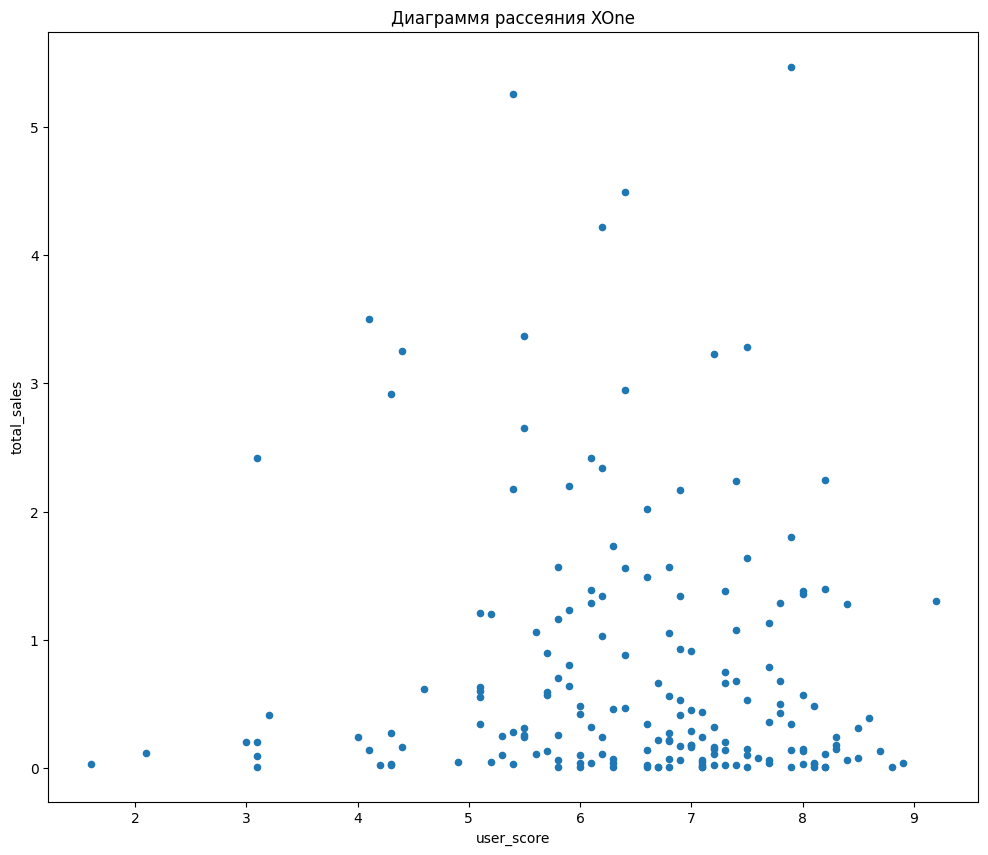

In [107]:
xone.plot(x='user_score', y='total_sales', kind='scatter', figsize=(12,10))
plt.title('Диаграммя рассеяния XOne')
plt.show()

Корреляция между оценками критиков и продажами

In [108]:
xone = data[(data['platform']=='XOne')&(data['critic_score']!=0)]
xone['critic_score'].corr(xone['total_sales'])

0.4169983280084017

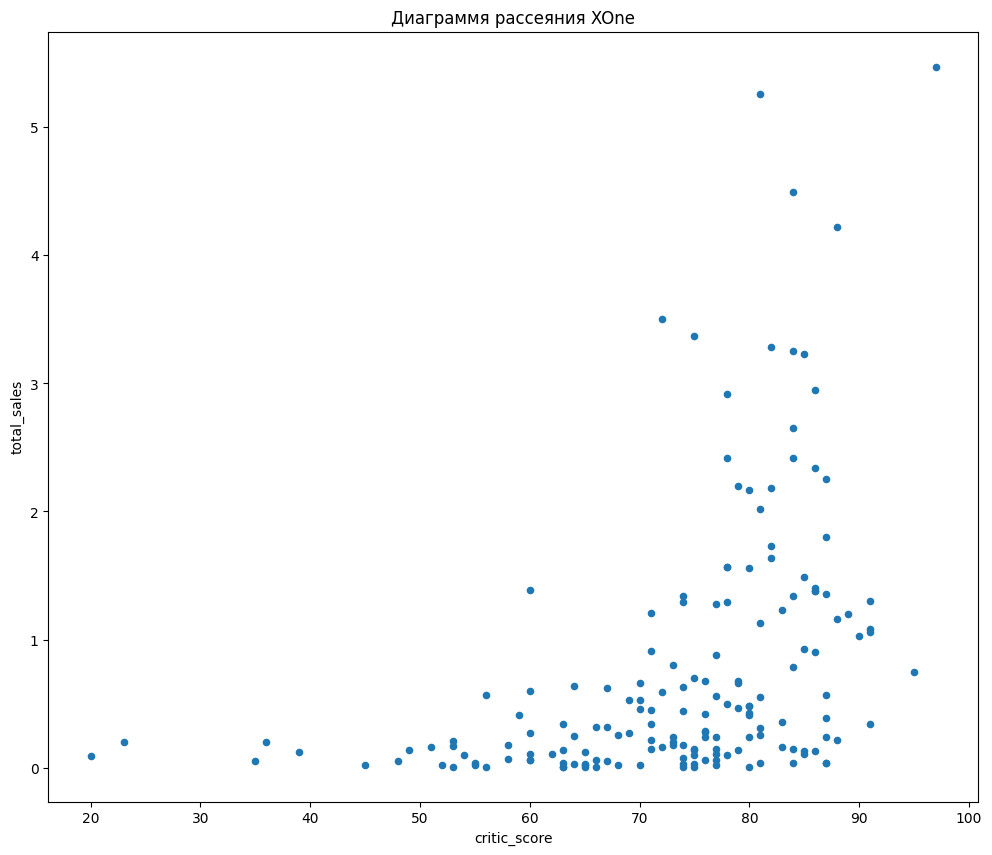

In [109]:
xone.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(12,10))
plt.title('Диаграммя рассеяния XOne')
plt.show()

Корреляция между отзывами пользователей и продажами XOne очень низкая.
Корреляция между отзывами критиков и продажами XOne умеренная, т.е. покупатели ориентируются на отзывы критиков, оставляя без внимания отзывы пользователей.

### Соотнесем выводы с продажами игр на других платформах.

Напишем функцию, которая будет отрисовывать графики рассеивания и считать корреляции для каждой платформы

In [110]:
def platforms_corr(name):
   
    plt.subplot(1, 2, 1)
    platform_data1 = data[(data['platform']==name)&data['user_score']]
    plt.scatter(x=platform_data1['user_score'], y=platform_data1['total_sales'])
    
  
    plt.subplot(1, 2, 2)
    platform_data2 = data[(data['platform']==name)&data['critic_score']]
    plt.scatter(x=platform_data2['critic_score'], y=platform_data2['total_sales'])
    
   
    plt.suptitle(f'Диаграммя рассеяния {name}')

    plt.show()
    
    user_corr = platform_data1['user_score'].corr(platform_data1['total_sales'])
    critic_corr = platform_data2['critic_score'].corr(platform_data2['total_sales'])
    
    if critic_corr < .2:
        print('Корреляция между отзывами критиков и продажамй', name.upper(), ': Очень слабая', critic_corr)
    elif critic_corr < .5:
        print('Корреляция между отзывами критиков и продажам', name.upper(), ': Слабая', critic_corr)
    elif critic_corr < .7:
        print('Корреляция между отзывами критиков и продажам', name.upper(), ': Средняя', critic_corr)
    elif critic_corr < .9:
        print('Корреляция между отзывами критиков и продажам', name.upper(), ': Высокая', critic_corr)
    else:
        print('Корреляция между отзывами критиков и продажам', name.upper(), ': Очень высокая', critic_corr)
    
    if user_corr <= .2:
        print('Корреляция между отзывами пользователей и продажами', name.upper(), ': Очень слабая', user_corr)
    elif user_corr < .5:
        print('Корреляция между отзывами пользователей и продажами', name.upper(), ': Умеренная', user_corr)
    elif user_corr < .7:
        print('Корреляция между отзывами пользователей и продажами', name.upper(), ': Высокая', user_corr)
    elif user_corr < .9:
        print('Корреляция между отзывами пользователей и продажами', name.upper(), ': Весьма высокая', user_corr)
    else:
        print('Корреляция между отзывами пользователей и продажами', name.upper(), ': Сильная', user_corr)
    print()

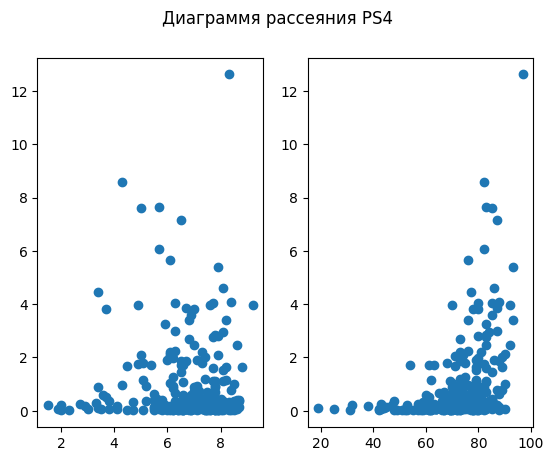

Корреляция между отзывами критиков и продажам PS4 : Слабая 0.40656790206178095
Корреляция между отзывами пользователей и продажами PS4 : Очень слабая -0.031957110204556424



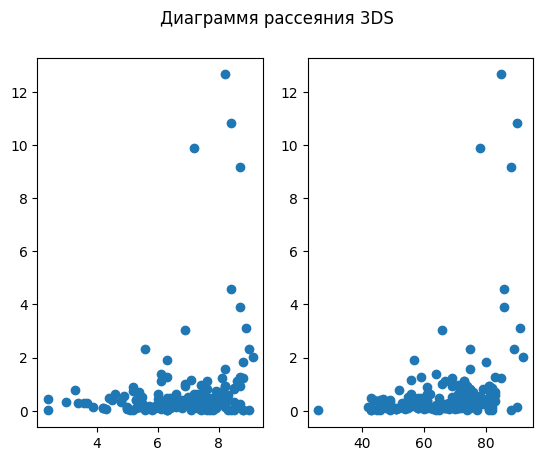

Корреляция между отзывами критиков и продажам 3DS : Слабая 0.3494009303924131
Корреляция между отзывами пользователей и продажами 3DS : Умеренная 0.22480798039571082



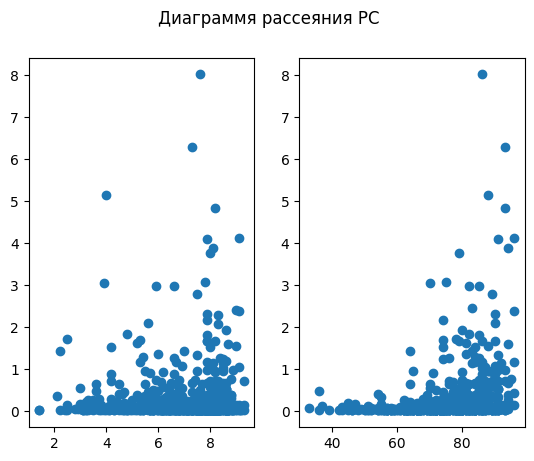

Корреляция между отзывами критиков и продажам PC : Слабая 0.2568867378948215
Корреляция между отзывами пользователей и продажами PC : Очень слабая 0.010475684621486417



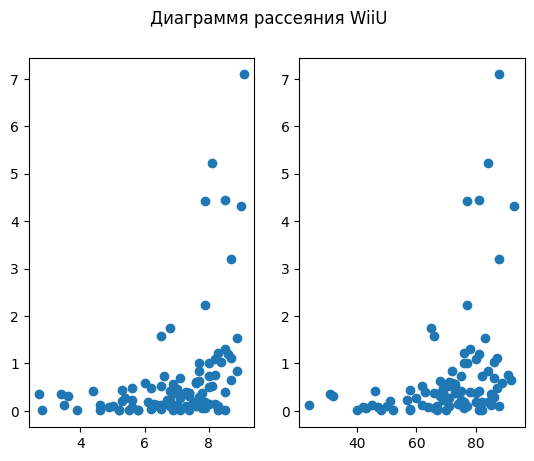

Корреляция между отзывами критиков и продажам WIIU : Слабая 0.34837976012017485
Корреляция между отзывами пользователей и продажами WIIU : Умеренная 0.4002190202148617



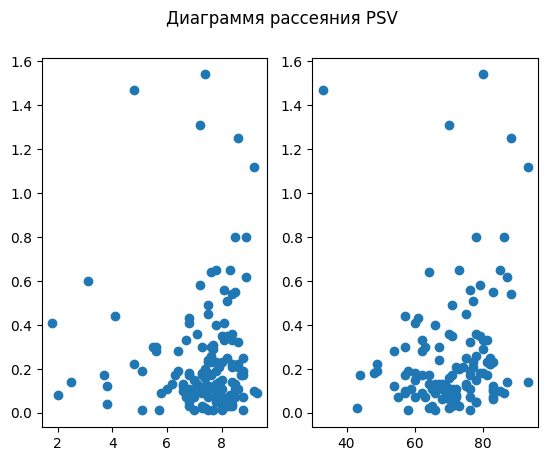

Корреляция между отзывами критиков и продажамй PSV : Очень слабая 0.1315167215429264
Корреляция между отзывами пользователей и продажами PSV : Очень слабая 0.013579522883028902



In [111]:
for platform in ['PS4', '3DS', 'PC', 'WiiU', 'PSV']:
    platforms_corr(platform)

У PS4, 3DS и WiiU наблюдается слабая связь между оценками критиков и продажами. А связь между оценками пользователей и продажами только у 3DS и WiiU оценивается как умеренная, у остальных платформ она очень слабая . Это говорит о том, что покупатели прислушиваются больше к критикам, а пользователи 3DS и WiiU к оценкам других пользователей. Корреляция между продажами и отзывами у пользователей PC и PSV отсутствует.

### Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [112]:
distrib_genre = games_top_6_platforms.pivot_table(index=['genre'], aggfunc={'name':'count', 'total_sales':'sum'}).sort_values(
    by='total_sales', ascending=False)
distrib_genre

,name,total_sales
genre,,
Action,470,85.70
Role-Playing,174,39.10
Shooter,70,27.75
Sports,88,24.20
Misc,85,15.81
Adventure,147,11.78
Fighting,35,9.47
Racing,47,8.38
Platform,28,7.12


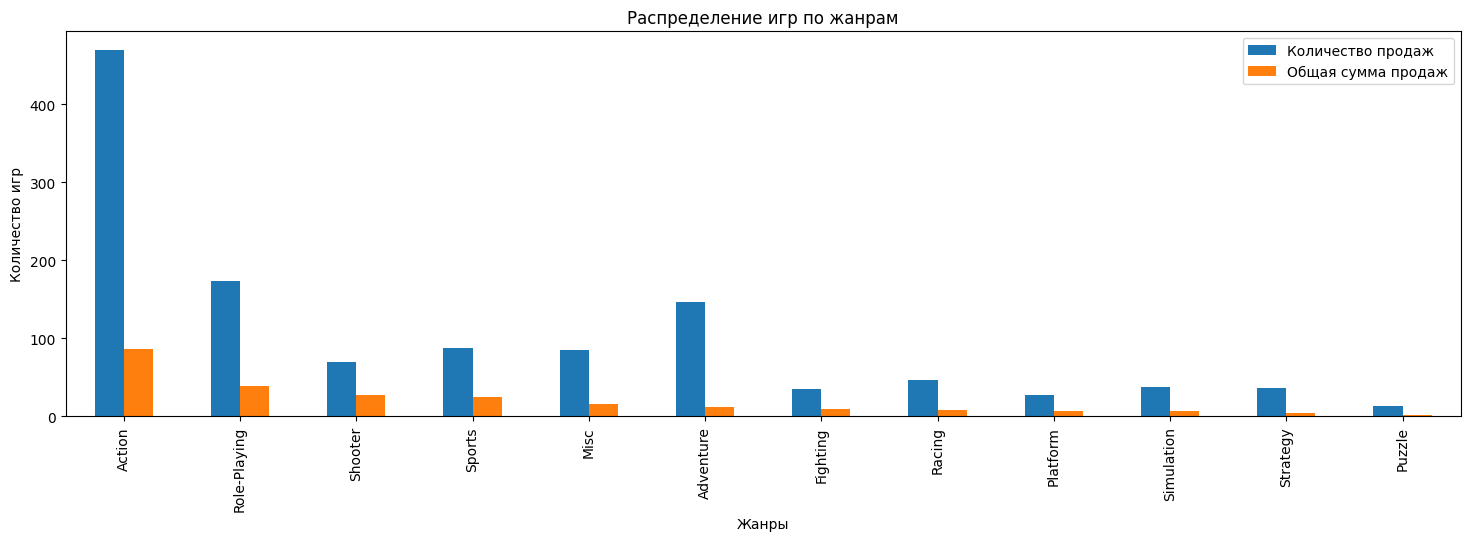

In [113]:
distrib_genre.plot(kind='bar', figsize=(18,5))
plt.title("Распределение игр по жанрам")
plt.xlabel("Жанры")
plt.ylabel("Количество игр")
plt.legend(['Количество продаж', 'Общая сумма продаж'])
plt.show()

In [114]:
distrib_genre.mean().round(2)

name           102.58
total_sales     20.13
dtype: float64

In [115]:
distrib_genre.median().round(2)

name           58.50
total_sales    10.62
dtype: float64

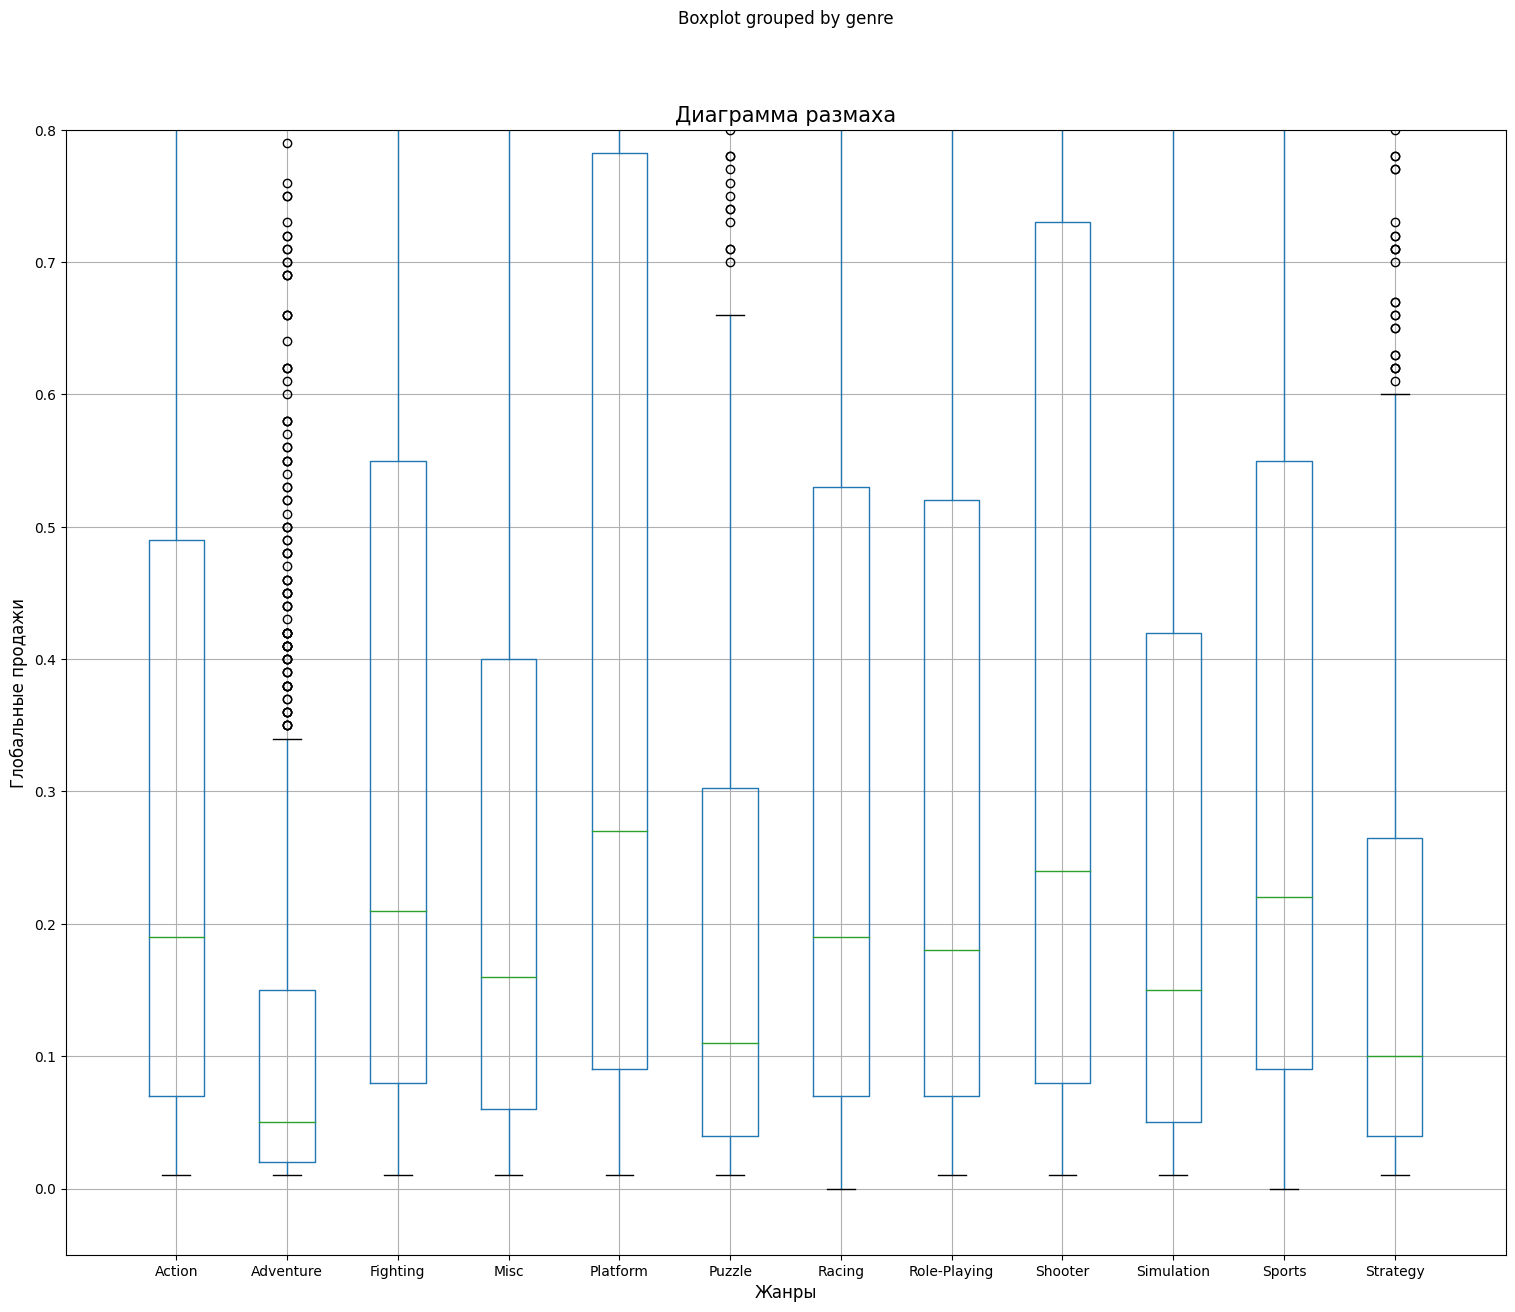

In [116]:
data.boxplot(column = 'total_sales', by='genre', figsize=(18,15))
plt.title('Диаграмма размаха', fontsize=15)
plt.xlabel('Жанры', fontsize=12)
plt.ylabel('Глобальные продажи',fontsize=12)
plt.ylim(-0.05, 0.8)
plt.xlim(0, 13) 
plt.show()

Явным лидером являются Экшн игры. Далее идут ролевые, шутеры и спортивные игры. Аутсайдеры - игры, которые требуют усидчивости: стратегии и головоломки.

## Шаг 4. Составим портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):
 - Самые популярные платформы (топ-5). Опишите различия в долях продаж.
 - Самые популярные жанры (топ-5). Поясните разницу.
 - Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [117]:
regions = ['na_sales', 'eu_sales', 'jp_sales']

In [118]:
def platform_country_pivot_tabl(region):
    region_pivot = pd.pivot_table(data, index='platform', values=region,
                                        aggfunc='sum').sort_values(region, ascending=False)
    region_top5 = region_pivot.head()
    print(region_top5)
    region_top5.plot.pie(y=region)
    plt.legend(bbox_to_anchor=( 1.05 , 1 ), loc='upper left', borderaxespad= 0 )
    plt.show()

          na_sales
platform          
X360        602.47
PS2         583.84
Wii         496.90
PS3         393.49
DS          382.40


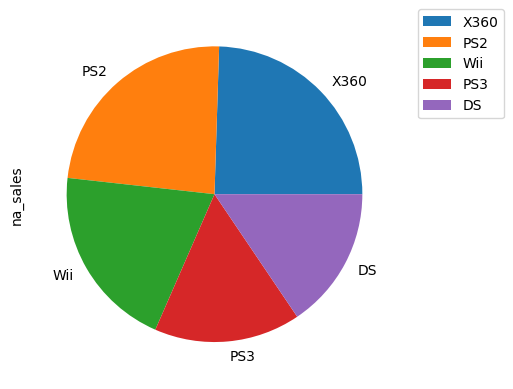

          eu_sales
platform          
PS2         339.29
PS3         330.29
X360        270.76
Wii         262.21
PS          213.61


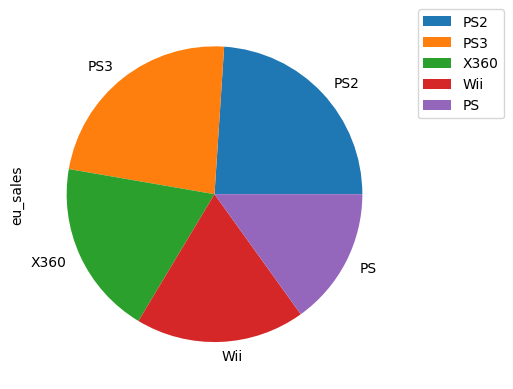

          jp_sales
platform          
DS          175.57
PS          139.82
PS2         139.20
SNES        116.55
3DS         100.67


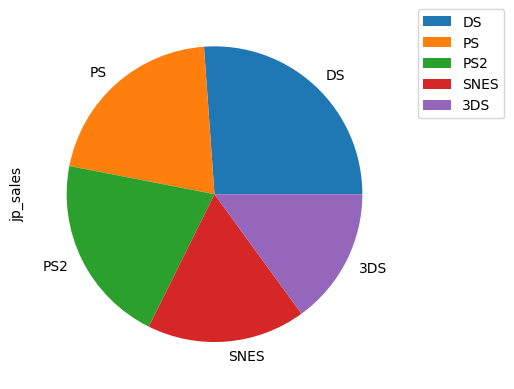

In [119]:
for region in regions:
    platform_country_pivot_tabl(region)

Рейтинг платформ:
- Топ 5 в Северной Америке: X360, PS2, Wii, PS3, DS 
- Топ 5 по Европейскому региону: PS3, PS2, X360, Wii, PS
- Топ 5 в Японии: DS, PS, PS2, SNES и 3DS
Судя по диаграммам распределение по долям относительно равномерное: по 25% первые 2 лидера в списке, оставшие 50% рынка делят 

In [132]:
def genre_country_pivot_tabl(region):
    region_pivot = pd.pivot_table(data, index='genre', values=region,
                                        aggfunc='sum').sort_values(region, ascending=False)
    region_top5 = region_pivot.head()
    print(region_top5)
    region_top5.plot.pie(y=region)
    plt.legend(bbox_to_anchor=( 1.05 , 1 ), loc='upper left', borderaxespad= 0 )
    plt.show()

          na_sales
genre             
Action      879.01
Sports      684.43
Shooter     592.24
Platform    445.50
Misc        407.27


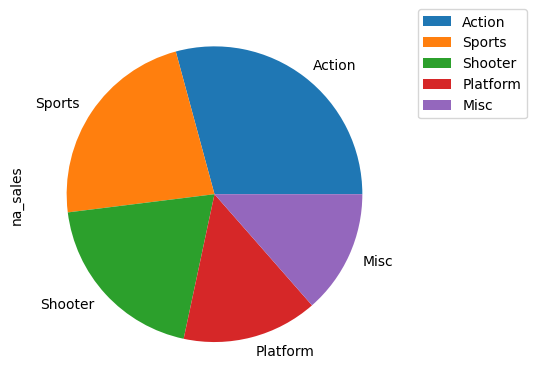

         eu_sales
genre            
Action     519.13
Sports     376.79
Shooter    317.34
Racing     236.51
Misc       212.74


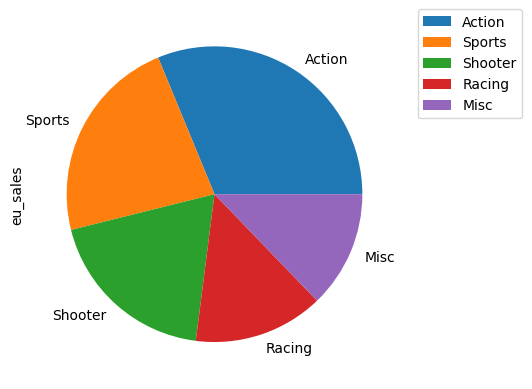

              jp_sales
genre                 
Role-Playing    355.41
Action          161.43
Sports          135.54
Platform        130.83
Misc            108.11


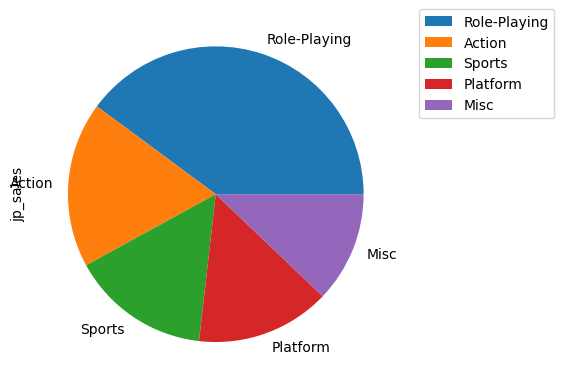

In [121]:
for region in regions:
    genre_country_pivot_tabl(region)    

Рейтинг жанров:

- Топ 5 по Северной Америке: Action, Sports, Shooter, Platform и Misc
- Топ 5 по Европейскому региону: Action, Sports, Shooter, Racing и Misc
- Топ 5 по Японии: Role-Playing, Action, Sports, Platform и Misc
Рейтинг Европы и Сев Америки очень схож как по распределени долей, так и по содержанию. Картина по рейтингу жанров  в Японии отличается. Лидером выстыпают рлевые игры, занимая более 30% в среди топ-5 жанров. 

In [122]:
def esrb_country_pivot_tabl(region):
    # Удалим строк с ретингом Unknown
    data_filtered = data[data['rating'] != 'Unknown']
    region_pivot = pd.pivot_table(data_filtered, index='rating', values=region,
                                        aggfunc='sum').sort_values(region, ascending=False)
    region_top5 = region_pivot.head()
    print(region_top5)
    region_top5.plot.pie(y=region)
    plt.legend(bbox_to_anchor=( 1.05 , 1 ), loc='upper left', borderaxespad= 0 )
    plt.show()

        na_sales
rating          
E        1292.99
T         759.75
M         748.48
E10+      353.32
K-A         2.56


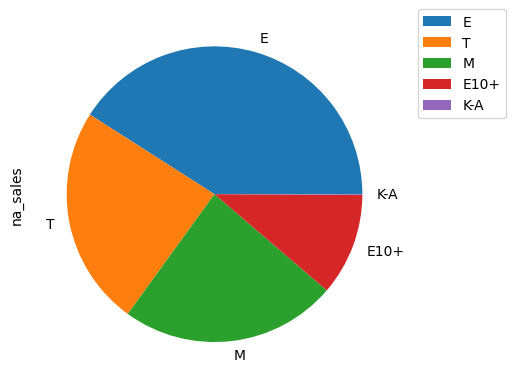

        eu_sales
rating          
E         710.25
M         483.97
T         427.03
E10+      188.52
AO          0.61


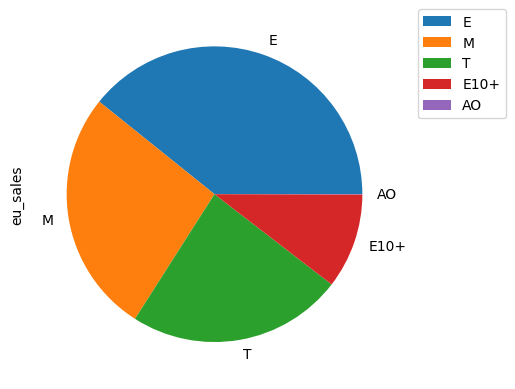

        jp_sales
rating          
E         198.11
T         151.40
M          64.24
E10+       40.20
K-A         1.46


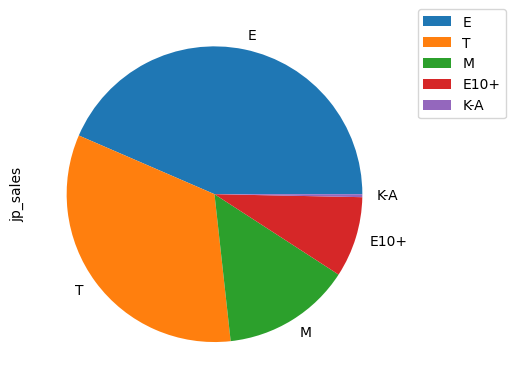

In [123]:
for region in regions:
    esrb_country_pivot_tabl(region)   

Во всех регионах лидируют продажи игр с рейтингов Е - для всех возрастных категорий. Игра не должна содержать звуков или изображений, которые могут напугать маленьких детей. Далее ситуация отличается- В Северной Америке и Япониии на втором месте игры для поростков, замыкают тройки лидеров игры категории 17+. В Европе на втором месте игры 17+, а на 3м  - для подростков. 

**ВЫВОД**

Составим портрет пользователя каждого региона: 

- Сев Америка: консоль - X360 или PS2, игра - Action или Sports с катеригорией для всех возрастов 
- Европа: консоль - PS второго или третьего поколения,  игра - Action или Sports с катеригорией для всех возрастов 
- Япония: консоль - DS или PS, игра - Role-Playing с катеригорией для всех возрастов.

## Шаг 5. Проверьте гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем гипотезы:
- H₀: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- H₁: Средние пользовательские рейтинги платформ Xbox One и PC различаются

In [124]:
xone_h = data[(data['platform']=='XOne') & (data['year_of_release']>=2014)]['user_score']
pc_h = data[(data['platform']=='PC') & (data['year_of_release']>=2014)]['user_score']

In [125]:
xone_h.mean()

4.772368421052631

In [126]:
pc_h.mean()

5.088741721854304

In [127]:
alpha = .05

results = stats.ttest_ind(xone_h.dropna(), pc_h.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 0.31981092459798116
Не получилось отвергнуть нулевую гипотезу


Значение p-value равно чуть меньше 32%. Таким образом, не получилось опровергнуть Нулевую гипотезу. То есть, каждый третий рейтинг двух платформ будет не одинаковым.

### Средние пользовательские рейтинги жанров Action и Sports разные

Сформулируем гипотезы:

- H₀: Средние пользовательские рейтинги жанров Action и Sports одинаковые
- H₁: Средние пользовательские рейтинги жанров Action и Sports различаются

In [128]:
genre_action_h = data[(data['genre']=='Action') & (data['year_of_release']>=2014)]['user_score']
genre_sports_h = data[(data['genre']=='Sports') & (data['year_of_release']>=2014)]['user_score']

In [129]:
genre_action_h.mean()

3.2437802907915994

In [130]:
genre_sports_h.mean()

4.121739130434783

In [131]:
alpha = .05

results = stats.ttest_ind(genre_action_h.dropna(), genre_sports_h.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0006646333120910831
Отвергаем нулевую гипотезу


Вероятности получить одинаковые средние рейнтинги по двум жанрам практическиравна нулю.

# Общий вывод

Была проведена предподготовка данные, название столбцов таблицы привели к нижнему регистру, исправили типы данных.
Определили, что аббревиатура TBD значит to be determined. То есть данные были нарочно не заполнены. Заменили NaN и 'tbd' на значение 0, т.к. на аналитику такой выбор заметно не повлияет.
Проведя анализ, мы выявили, что количество игр на игровые приставки и компьютеры начало расти с большой скоростью с 90х до 2008 года. С 2009 года после того как массово начали создавать мобильные приложения и игры, произошел резкий спад разработок консольных игр
За весь период консольных приставок самые популярные оказались: 'XOne', '3DS', 'PC', 'WiiU', 'PSV'
Также мы выявили, что средняя продолжительность жизни игровой приставки составляет порядка 8-10 лет. Самый пик продаж наступает примерно через 5 лет после выпуска консоли.

Проведя анализ оценок пользователей и критиков, мы выявили, что оценки взаимосвязаны с продажами самих игр, но не сильно.
Так же определили, что самый популярный жанр за все время это action. На последнем месте puzzle и strategy.

После мы составили портрета пользователей каждого региона.
Выяснили, что в Северной Америке самые популярные жанры это action, sports, shooter. Игровые приставки : XBOX, PS2 . А по рейтингу игр люди предпочитают игры с рейтингами: "для всех", "от 13 и выше" и "от 17 и выше".
В Европе же, популярные жанры точно такие же как и в Северной Америке. Но приставки по предпочитают по следующей очередности: PS2, PS3. Рейтинг игр отличается лишь вторым местом, на втором месте у них от 17 и выше, а на третьем 13 и выше.
В японии люди предпочитают игровые приставки: DS, PS, PS2. А жанры игры : Role-playing, action и sports. Рейтинг игр аналогичный Северной Америке.

Исходя из всех данных предполагаем, что лучше всего продавать игры для таких приставок как Sony Playstation 4
Жанры необходимо выбирать action и выбирать игры с рейтингом "для всех" или "от 17 и выше", тогда продажи будут значительно больше, чем если продавать другие игры.